In [60]:
import pandas as pd
import numpy as np

import scipy
import scipy.sparse

import time
import string
import random
import datetime

from nltk.tokenize.casual import TweetTokenizer
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pymorphy2

from collections import Counter

from sklearn.metrics import accuracy_score
from sklearn.cross_validation import train_test_split
from sklearn import naive_bayes
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.cross_validation import cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import ShuffleSplit
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.learning_curve import learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import NMF, LatentDirichletAllocation

import xgboost as xgb

In [73]:
#global constants
FIG_SIZE = (15, 6)

TOP_WORDS = 20
TOPICS_COUNT = 10

#почему-то нет некоторых знаков пунктуации и части стоп-слов
russian_stops = [ u'без', u'более', u'бы', u'был', u'была', u'были', u'было', u'быть', u'вам', u'вас', u'ведь', u'весь', u'вдоль', u'вместо', u'вне', u'вниз', u'внизу', u'внутри', u'во', u'вокруг', u'вот', u'все', u'всегда', u'всего', u'всех', u'вы', u'где', u'да', u'давай', u'давать', u'даже', u'для', u'до', u'достаточно', u'его', u'ее', u'её', u'если', u'есть', u'ещё', u'же', u'за', u'заисключением', u'здесь', u'из', u'из-за', u'или', u'им', u'иметь', u'их', u'как', u'как-то', u'кто', u'когда', u'кроме', u'кто', u'ли', u'либо', u'мне', u'может', u'мои', u'мой', u'мы', u'на', u'навсегда', u'над', u'надо', u'наш', u'не', u'него', u'неё', u'нет', u'ни', u'них', u'но', u'ну', u'об', u'однако', u'он', u'она', u'они', u'оно', u'от', u'отчего', u'очень', u'по', u'под', u'после', u'потому', u'потомучто', u'почти', u'при', u'про', u'снова', u'со', u'так', u'также', u'такие', u'такой', u'там', u'те', u'тем', u'то', u'того', u'тоже', u'той', u'только', u'том', u'тут', u'ты', u'уже', u'хотя', u'чего', u'чего-то', u'чей', u'чем', u'что', u'чтобы', u'чьё', u'чья', u'эта', u'эти', u'это']
custom_stops = [u'...', u'ещё', u'это', u'весь', u'..', u'—', u'я', u'и', u'a', u'\u2026', u'rt', 'rt', u'всё' u'«',  u'»']
custom_stops += russian_stops
stops = set(stopwords.words('russian') + list(string.punctuation) + custom_stops + list(string.digits))

In [71]:
#убираем шаблоны: веб-ссылки, ссылка на автора при ответе.
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

#для тематического моделирования может понадобится возвращать твит не как строку, но как массив слов
def remove_retweet(msg, as_array = False):
    if as_array:
        return filter(lambda x:x[0]!='@' and not x.startswith('http') and not is_number(x), msg.split())
    else:
        return ' '.join(filter(lambda x:x[0]!='@' and not x.startswith('http') and not is_number(x), msg.split()))

#нормализация слова
morph = pymorphy2.MorphAnalyzer()
def normal_form(word):      
    return morph.parse(word)[0].normal_form

def convert_to_normal(doc):
    return ' '.join([normal_form(w.lower()) for w in doc.split()])

def remove_stop_words(words):
    return [w.lower() for w in words if w.lower() not in stops and not w.startswith('#')]

tknzr = TweetTokenizer()
def tweet_tokenize(msg):
    return [t.lower() for t in tknzr.tokenize(msg)]

def convert_date(timestamp):
    date = datetime.datetime.fromtimestamp(timestamp)
    h = date.hour
    
    if h >= 23 or h <= 5:
        d_type = 0 #'Night'
    elif h > 5 and h <= 11:
        d_type = 1 #'Morning'
    elif h > 11 and h <= 18:
        d_type = 2 #'Midday'
    else:
        d_type = 3 #'Evening'
    
    return pd.Series({'Weekday':date.weekday(), 'DayPart': d_type})


In [4]:
import scipy.sparse as sp

def _class_frequencies(X, y):
    labels = np.unique(y)
    if len(labels) > 2:
        raise ValueError("Delta works only with binary classification problems")

    # Indices for each type of labels in y
    N1 = np.where(y == labels[0])[0]
    N2 = np.where(y == labels[1])[0]

    # Number of positive documents that each term appears on
    df1 = np.bincount(X[N1].nonzero()[1], minlength=X.shape[1])
    # Number of negative documents that each term appears on
    df2 = np.bincount(X[N2].nonzero()[1], minlength=X.shape[1])

    return N1.shape[0], df1, N2.shape[0], df2

class DeltaTfidfTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y = None):
        if not sp.issparse(X):
            X = sp.csc_matrix(X)

        n_samples, n_features = X.shape

        if y is None:
            raise ValueError("Labels are needed to determine Delta idf")

        N1, df1, N2, df2 = _class_frequencies(X, y)
        delta_idf = np.log((df1 * float(N2) + 1) /
                           (df2 * N1 + 1))

        # Maybe scale delta_idf to only positive values (for Naive Bayes, etc) ?
        self._idf_diag = sp.spdiags(delta_idf,
                                    diags=0, m=n_features, n=n_features)
       

        return self

    def transform(self, X):
        if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
            X = sp.csr_matrix(X, copy=True)
        else:
            X = sp.csr_matrix(X, dtype=np.float64, copy=True)

        n_samples, n_features = X.shape

        expected_n_features = self._idf_diag.shape[0]
        if n_features != expected_n_features:
            raise ValueError('Wrong shape! got: %d expected: %d' % (n_features, expected_n_features))
            
        # *= doesn't work
        X = X * self._idf_diag
            
        return X

    @property
    def idf_(self):
            return np.ravel(self._idf_diag.sum(axis=0))
        
class DeltaTfidfVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, min_df = 1, ngram_range = (1, 1), stop_words = list(), tokenizer = None):
        self.min_df = min_df
        self.stop_words = stop_words
        self.ngram_range = ngram_range
        self.tokenizer = tokenizer
        
        self.vectorizer = CountVectorizer(min_df = self.min_df, ngram_range = self.ngram_range,
                                          stop_words = self.stop_words, tokenizer = self.tokenizer)
        self.trans = DeltaTfidfTransformer()
    
    def fit(self, X, y = None):
        self.trans.fit(self.vectorizer.fit_transform(X), y)
    
    def transform(self, X):
        return self.trans.transform(self.vectorizer.transform(X))
    
    def fit_transform(self, X, y = None):
        self.fit(X, y)        
        return self.transform(X)    
    
    def weight_of_words(self, is_sorted = False):
        if is_sorted:
            return sorted(zip(self.vectorizer.vocabulary_, self.trans.idf_), key = lambda x: x[1])
        else:
            return zip(self.vectorizer.vocabulary_, self.trans.idf_)
            

In [5]:
class CSCTransformer(TransformerMixin):
    def transform(self, X, y=None, **fit_params):
        return X.tocsc()

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

In [59]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

## Тестирование моделей
Тестирование качества предсказания моделей, используя accuracy score (процент верных ответов).
Проверяется два метода преобразования данных: tf-idf векторизация и delta tf-idf векторизация (http://ebiquity.umbc.edu/_file_directory_/papers/446.pdf)
В случае tf-idf векторизации все "веса" положительны и можно использовать байесовские методы,при delta tf-idf веса могут быть отрицательными и байесовские методы не подходят.

Почему-то качество работы что с delta tf-idf, что с обычным tf-idf примерно одинаково (кривые руки?)

In [6]:
def test_models(sizes, models, delta_idf = True, n_gramms_max = 1, debug_lvl = 0, max_words = [None]):
    ret = dict()
    
    for n_gramm in range(1, n_gramms_max + 1):
        scores = {m[0]: [] for m in models}

        if delta_idf:
            vectorizer = DeltaTfidfVectorizer(min_df = 5, ngram_range = (1, n_gramm),
                                              stop_words = stops, tokenizer = tweet_tokenize)
        else:
            vectorizer = TfidfVectorizer(min_df = 5, max_df=0.95, ngram_range= (1, n_gramm),
                                         stop_words = stops, tokenizer = tweet_tokenize)

        for s in sizes:
            X = pd.concat([pos[:s], neg[:s]], ignore_index=True)

            s = X.shape[0]
            y = np.array(X['ttype'])

            X_tweets = X['ttext'].apply(remove_retweet)

            if debug_lvl >= 1:
                print '*** starting process %d tweets ***' % s                

            for m in models:

                start_time = time.time()
                pipe = make_pipiline( vectorizer,  m[1])

                cv_score = np.mean(cross_val_score(pipe, X_tweets, y, cv = 5, n_jobs = 5))

                if debug_lvl >= 2:
                    print 'scoring for \'%s\' completed in: %s min' % (m[0], round(((time.time() - start_time) / 60), 2))

                scores[m[0]].append(cv_score) 

        plt.figure(figsize=FIG_SIZE)

        for m in scores:
            plt.plot(sizes, scores[m], label = m)

            if debug_lvl >= 3:
                print m, scores[m]

        ret[n_gramm] = scores

        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad = 0.)
        plt.title('n-gramms: %d' % n_gramm)
        
    return ret
    

In [37]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=FIG_SIZE)
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt, test_scores

def learning_curves(models, X, n_jobs = 1,
                    vectorizer = TfidfVectorizer(min_df = 3, max_df = 0.95,  stop_words = stops, tokenizer = tweet_tokenize)):
    scores = dict()
    X_tweets = np.array(X['ttext'].apply(remove_retweet))
    y = np.array(X['ttype']).ravel()
    
    for m in models:
        if m[0] == 'XGB':
            print 'it\'s XGB!'
            pipe = make_pipeline( vectorizer, CSCTransformer() , m[1])
        else:      
            pipe = make_pipeline( vectorizer, m[1])
        
        cv = ShuffleSplit(X_tweets.shape[0], n_iter=100, test_size=0.25, random_state=0)
        
        plt, test_scores = plot_learning_curve(pipe, m[0], X_tweets, y, ylim=(0.6, 1.01), cv=cv, n_jobs=n_jobs)
        plt.show()
        
        scores[m] = test_scores
        
    return scores

In [19]:
neg = pd.read_csv('train_data/negative.csv', sep=';')
pos = pd.read_csv('train_data/positive.csv', sep=';')

# оставляем только класс и сам текст сообщения
neg = neg.drop(['id', 'tdate', 'tmane', 'trep', 'trtw', 'tfav',
       'tstcount', 'tfrien', 'listcount', 'Unnamed: 11', 'Unnamed: 12',
       'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16',
       'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20',
       'Unnamed: 21', 'Unnamed: 22'], axis=1)

pos = pos.drop(['id', 'tmane', 'trep', 'trtw', 'tfav',
       'tstcount', 'tfrien', 'listcount', 'Unnamed: 11', 'Unnamed: 12',
       'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16',
       'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20',
       'Unnamed: 21', 'Unnamed: 22'], axis=1)

X = pd.concat([pos, neg], ignore_index=True)

KeyboardInterrupt: 

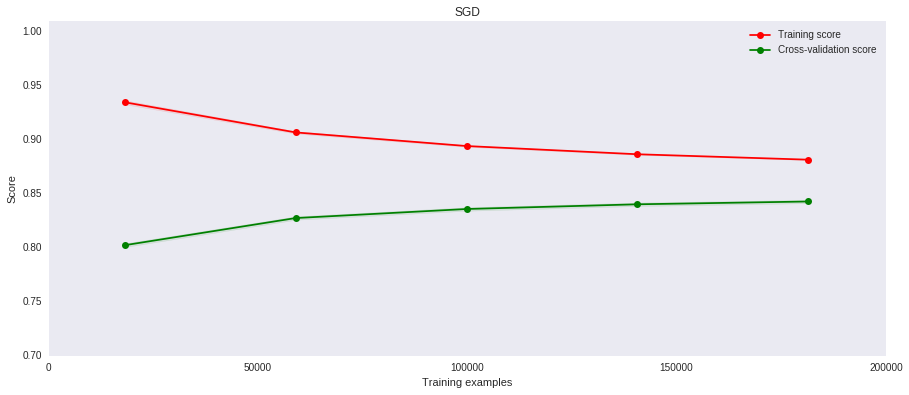

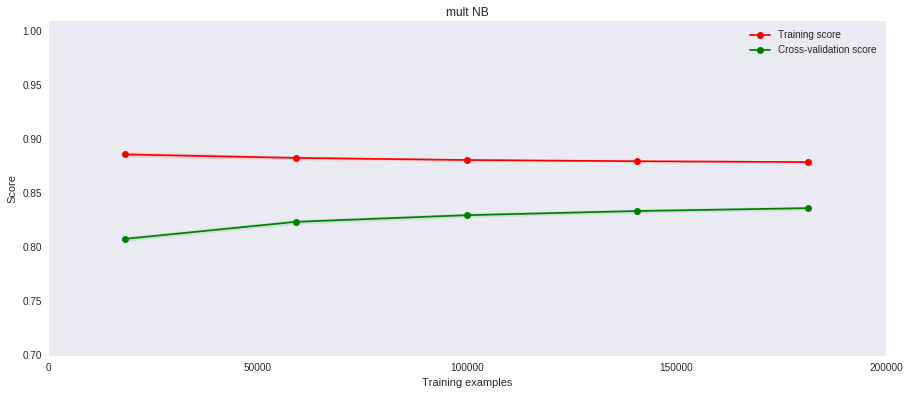

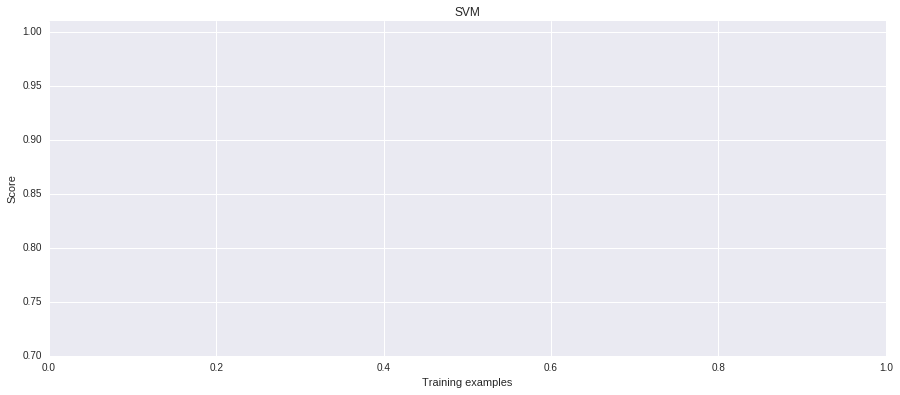

In [12]:
models_to_test = [
    ('SGD', SGDClassifier(n_iter=50, loss='modified_huber')),
    ('mult NB', naive_bayes.MultinomialNB()),
    ('SVM', svm.LinearSVC())
    ]

learning_curves(models_to_test, X)

In [ ]:
models_to_test = [
    ('Linear SVC', svm.LinearSVC()),
    ('SGD', SGDClassifier(n_iter=50, loss='modified_huber')),
    ('Voting', VotingClassifier(estimators= [
                              ('SVM', svm.LinearSVC()),
                              ('SGD', SGDClassifier(n_iter=50, loss='modified_huber')),
                              ('Ada', AdaBoostClassifier(SGDClassifier(n_iter=50, loss='modified_huber')))              
                             ]))
    ]

# В оригинальном датасете около 111.000 сообщений каждого класса. 
# Слишком долго работать со всеми при прототипировании
sizes_to_test = [1000, 2000, 5000, 10000, 25000]

scores = test_models(sizes_to_test, models_to_test, delta_idf = True, n_gramms_max = 3, max_words = [0.95])

In [ ]:
models_to_test = [
    #('mult bayes', naive_bayes.MultinomialNB()),
    #('XGB', xgb.XGBClassifier(n_estimators=1200, max_depth=5, learning_rate=0.02)), #too low accuracy
    ('Linear SVC', svm.LinearSVC()),
    #('Non-linear SVC', svm.SVC(gamma=0.1)), #takes too long time to compute 
    ('SGD', SGDClassifier(n_iter=50, loss='modified_huber')),
    ('bern bayes', naive_bayes.BernoulliNB()),
    #('Ada', AdaBoostClassifier(SGDClassifier(n_iter=50, loss='modified_huber'))),
#     ('Voting', VotingClassifier(estimators= [('mult NB', naive_bayes.MultinomialNB()),
#                           ('SVM', svm.LinearSVC()),
#                           ('SGD', SGDClassifier(n_iter=50, loss='modified_huber')),
#                           ('bern bayes', naive_bayes.BernoulliNB())              
#                          ]))

]

# В оригинальном датасете около 111.000 сообщений каждого класса. 
# Слишком долго работать со всеми при прототипировании
sizes_to_test = [1000, 2000, 5000, 10000, 25000]

scores = test_models(sizes_to_test, models_to_test, delta_idf = False, max_words=[5000, 10000, None])

## Веса
Веса н-грамм при использовании delta tf-idf векторизации.

In [7]:
X = pd.concat([pos, neg], ignore_index=True)

X_tweets = X['ttext'].apply(remove_retweet)
y = X['ttype']

vectorizer = DeltaTfidfVectorizer(min_df = 3, ngram_range = (1, 3),
                          stop_words = stops, tokenizer = tweet_tokenize)

vectorizer.fit(X_tweets, y)

scores = vectorizer.weight_of_words(is_sorted = True)

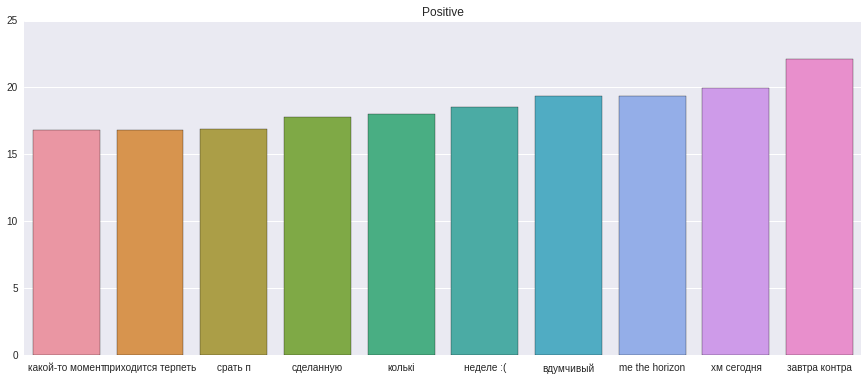

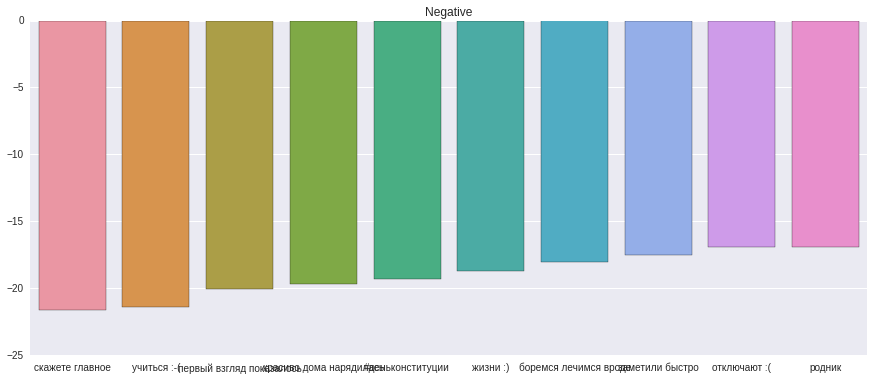

In [8]:
plt.figure(figsize=FIG_SIZE)
sns.barplot(x=[w[0] for w in scores[-10:]], y=[w[1] for w in scores[-10:]])
sns.plt.title('Positive')

plt.figure(figsize=FIG_SIZE)
sns.barplot(x=[w[0] for w in scores[:10]], y=[w[1] for w in scores[:10]])
sns.plt.title('Negative')

## Веса
Частота появления определенных токенов в позитивных и негативных твитах

In [9]:
X_tweets = list(pos['ttext'])

words = list()

for s in X_tweets:
    words += remove_stop_words(tweet_tokenize(s))

words_counts = Counter(words)
words_counts = sorted([(w, words_counts[w]) for w in words_counts], key=lambda x: x[1])

pos_words = words_counts[-15:]

X_tweets = list(neg['ttext'])

words = list()

for s in X_tweets:
    words += remove_stop_words(tweet_tokenize(s))

words_counts = Counter(words)
words_counts = sorted([(w, words_counts[w]) for w in words_counts], key=lambda x: x[1])

neg_words = words_counts[-15:]

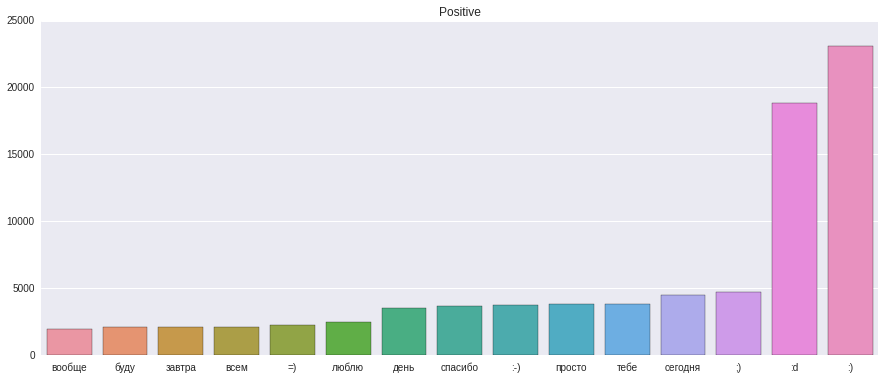

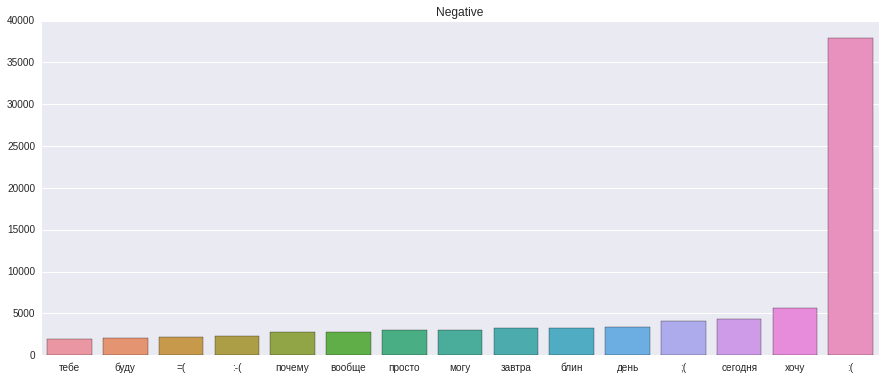

In [10]:
plt.figure(figsize=FIG_SIZE)
sns.barplot(x=[w[0] for w in pos_words], y=[w[1] for w in pos_words])
sns.plt.title('Positive')

plt.figure(figsize=FIG_SIZE)
sns.barplot(x=[w[0] for w in neg_words], y=[w[1] for w in neg_words])
sns.plt.title('Negative')

## Зависимость между днем и тональностью
Проверяется гипотеза, влияет ли день недели и время суток на тональность твита (например, утром твиты негативнее, а вечером позитивнее).
Проверить влияние времени года на тональность нельзя т.к. в данных представлены твиты только за декабрь и январь.
Видно, что зависимость есть (в пятницу очень мало позитивных твитов, но их больше с пон. по четверг), но тесты показали, что такой подход не работает (мало данных?)

In [12]:
neg = pd.read_csv('data/train/negative.csv', sep=';')
pos = pd.read_csv('data/train/positive.csv', sep=';')

neg = neg.drop(['id', 'trep', 'trtw', 'tfav',
       'tstcount', 'tfrien', 'listcount', 'Unnamed: 11', 'Unnamed: 12',
       'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16',
       'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20',
       'Unnamed: 21', 'Unnamed: 22'], axis=1)

pos = pos.drop(['id', 'trep', 'trtw', 'tfav',
       'tstcount', 'tfrien', 'listcount', 'Unnamed: 11', 'Unnamed: 12',
       'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16',
       'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20',
       'Unnamed: 21', 'Unnamed: 22'], axis=1)

pos['ttext'] = pos['ttext'].apply(remove_retweet)
neg['ttext'] = neg['ttext'].apply(remove_retweet)

In [13]:
def convert_date(timestamp):
    date = datetime.datetime.fromtimestamp(timestamp)
    h = date.hour
    
#     if h <= 6:
#         d_type = 'Night'
#     elif h <= 12:
#         d_type = 'Morning'
#     elif h <= 18:
#         d_type = 'Midday'
#     else:
#         d_type = 'Evening'
    
    if h >= 23 or h <= 5:
        d_type = 'Night'
    elif h > 5 and h <= 11:
        d_type = 'Morning'
    elif h > 11 and h <= 18:
        d_type = 'Midday'
    else:
        d_type = 'Evening'
    
    return pd.Series({'Weekday':date.strftime('%A'), 'DayPart': d_type})

def rename_type(num):
    if num == -1:
        return 'neg'
    else:
        return 'pos'

In [1679]:
neg_date = neg['tdate'].apply(convert_date)
pos_date = pos['tdate'].apply(convert_date)
X = pd.concat([neg, pos])
X = pd.concat([X, pd.concat([neg_date, pos_date])], axis=1)

X['ttype'] = X['ttype'].apply(rename_type)

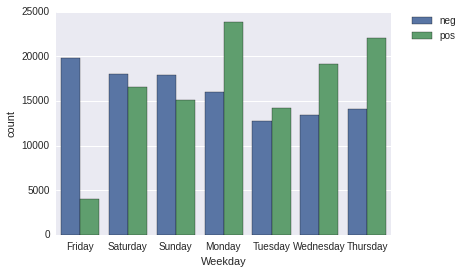

In [1690]:
sns.countplot(x='Weekday', data=X, hue='ttype')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

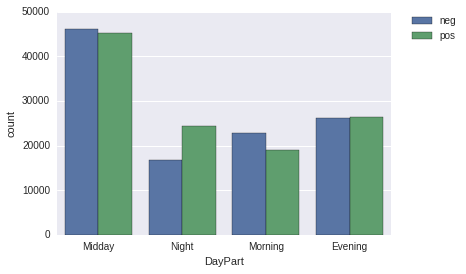

In [1691]:
sns.countplot(x='DayPart', data=X, hue='ttype')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Зависимость между тональностью и параметрами пользователей
Проверяется зависимость между типом твита и то, насколько пользователь часто пишет, сколько у него подписчиков и т.п. Была выдвинута гипотеза, что такая зависимость может быть поскольку некоторые пользователи склонные к негативным сообщениям, а некоторые наоборот, следовательно, более негативные/позитивные пользователи могут пользоваться бОльшей или меньшей популярностью, следовательно, исходя из параметров пользователя можно предсказать тональность твита.

Заметной корреляции обнаружено не было, поэтому данные свойства не используются в анализе.

In [212]:
neg = pd.read_csv('data/train/negative.csv', sep=';')
pos = pd.read_csv('data/train/positive.csv', sep=';')

neg = neg.drop(['Unnamed: 11', 'Unnamed: 12',
       'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16',
       'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20',
       'Unnamed: 21', 'Unnamed: 22', 'id', 'trep'], axis=1)

pos = pos.drop(['Unnamed: 11', 'Unnamed: 12',
       'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16',
       'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20',
       'Unnamed: 21', 'Unnamed: 22', 'id', 'trep'], axis=1)

X = pd.concat([pos, neg])

In [213]:
X.select_dtypes(include=['float', 'int64']).columns.values

array(['tdate', 'ttype', 'trtw', 'tfav', 'tstcount', 'tfrien', 'listcount'], dtype=object)

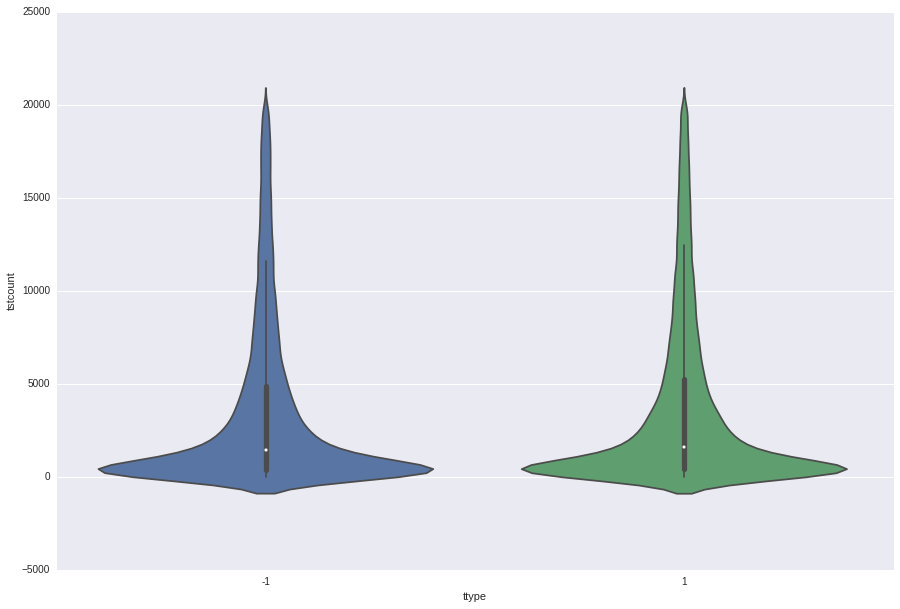

In [214]:
# Зависимости между тоном твитов и числом твитов пользователя нет
plt.figure(figsize=(15, 10))
sns.violinplot(x='ttype', y='tstcount', data=X.loc[X['tstcount'] < 20000])

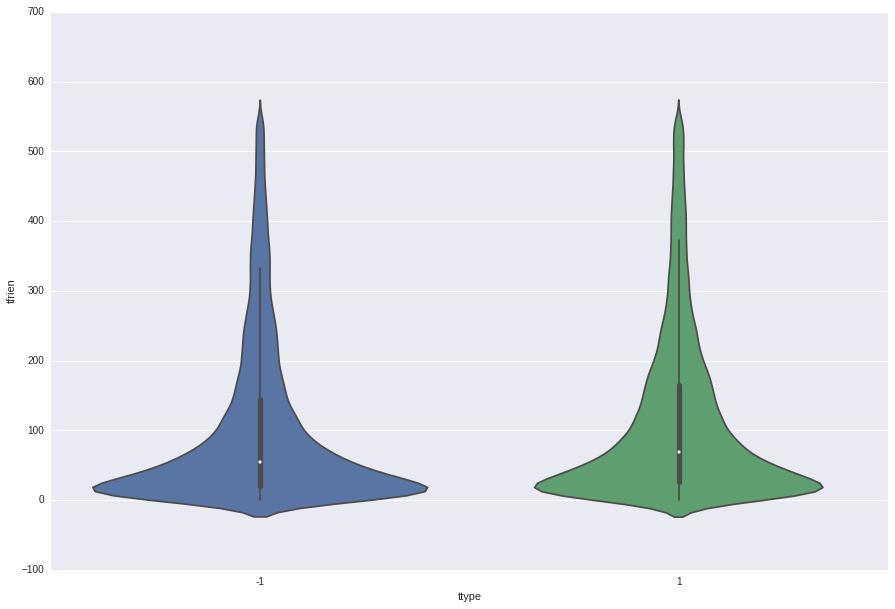

In [215]:
# У людей, которые пишут позитивные твиты, больше друзей? Небольшая корреляция есть (вроде)
plt.figure(figsize=(15, 10))
sns.violinplot(x='ttype', y='tfrien', data=X.loc[X['tfrien'] < 550])

In [128]:
pos['tfrien'].describe()

count     114910.000000
mean         785.609799
std        10790.510490
min            0.000000
25%           32.000000
50%           97.000000
75%          282.000000
max      1582807.000000
Name: tfrien, dtype: float64

In [129]:
neg['tfrien'].describe()

count     111922.000000
mean         565.517941
std         8583.052619
min            0.000000
25%           23.000000
50%           71.000000
75%          237.000000
max      1236196.000000
Name: tfrien, dtype: float64

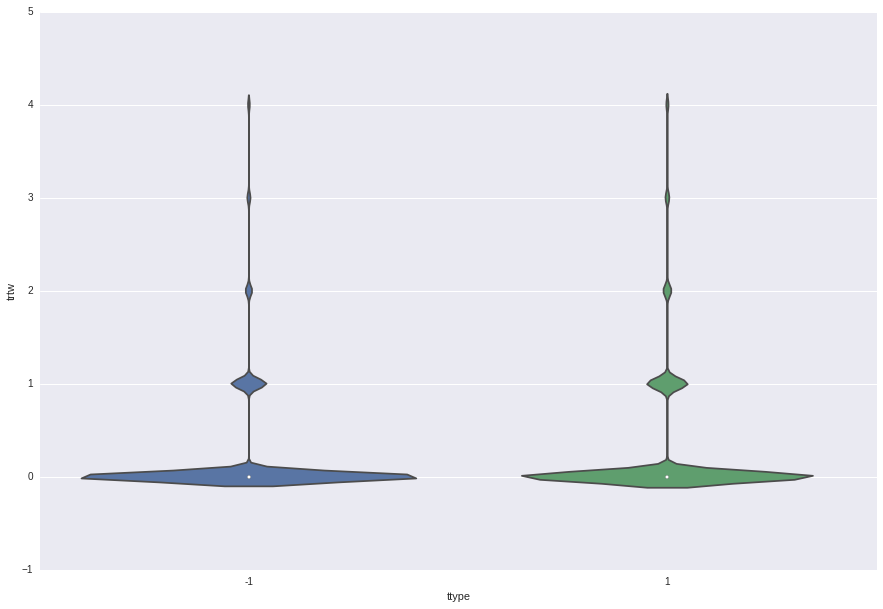

In [134]:
# Позитивные и негативные посты ретвитят примерно одинаково
plt.figure(figsize=(15, 10))
sns.violinplot(x='ttype', y='trtw', data=X.loc[X['trtw'] < 5])

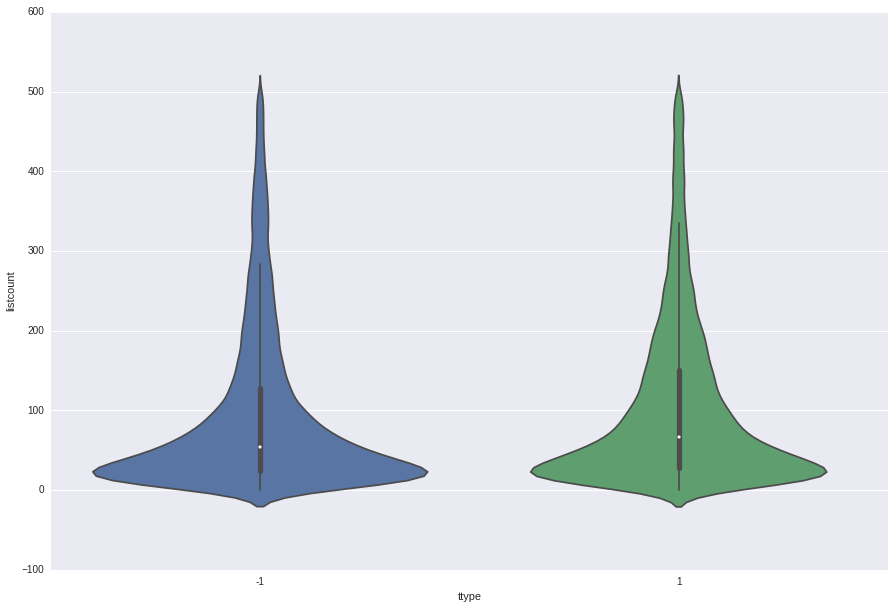

In [145]:
# Люди с позитивными постами чаще попадают в подписки
plt.figure(figsize=(15, 10))
sns.violinplot(x='ttype', y='listcount', data=X.loc[X['listcount'] < 500])

In [13]:
vectorizer = TfidfVectorizer(min_df = 3, max_df = 0.95, stop_words = stops, tokenizer = tweet_tokenize)
tfidf = vectorizer.fit_transform(X['ttext'].apply(remove_retweet))

nmf = NMF(n_components=TOPICS_COUNT, random_state=1, alpha=.1, l1_ratio=.5).fit(tfidf)

In [16]:
tfidf_feature_names = vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, TOP_WORDS)

Topic #0:
:( могу скучаю почему блин жаль плохо болит скучно жалко делать дома что-то никто хочется бля ааа время такое эх
Topic #1:
:) всем люблю утро привет доброе время пока нравится круто такая кстати ахаха настроение ахах нам ночи приятно рождения скоро
Topic #2:
:d d dd ахах ахаха ахахах ddd ахахаха знаю буду такая лол дааа люблю вообще мама такое ладно ага норм
Topic #3:
хочу спать домой идти школу обратно тату посмотреть делать устала увидеть ааа тобой гулять кушать ужасно ехать дома никуда безумно
Topic #4:
спасибо люблю большое приятно всем ;) огромное вечер настроение з <3 читаешь ахах поддержку иосиф милая #євромайдан дорогая поздравления брат
Topic #5:
просто люблю знаю могу ужасно пиздец ужас супер ааа хочется нужно ;) жизни настроение капец ахах плохо нравится такая ахаха
Topic #6:
:-) нь л юм #follow такое o привет #ff ладно пока байна блять бля плохо лет кстати слишком ой :-d
Topic #7:
тебе скучаю удачи рождения нужна днем ёлка добра новый привет ;) нравится счастья з 

In [17]:
tf_vectorizer = CountVectorizer(min_df = 3, max_df = 0.95, stop_words = stops, tokenizer = tweet_tokenize)
tf = tf_vectorizer.fit_transform(X['ttext'].apply(remove_retweet))

lda = LatentDirichletAllocation(n_topics=TOPICS_COUNT, max_iter=5,
                                learning_method='online', learning_offset=50.,
                                random_state=0).fit(tf)

In [19]:
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, TOP_WORDS)

Topic #0:
:( могу тебе нужно жизни утра одна сегодня часа сильно человек моей столько который ;( щас каникулы никак второй такого
Topic #1:
:( :d блин что-то болит вообще мной вроде кажется блять пиздец ненавижу думала кого самое грустно самый ахах прям кстати
Topic #2:
:( почему :-( жаль такое о_о нг нам :-) ночь раньше голова чувствую круто телефон году больно походу найти печально
Topic #3:
:( вообще делать время домой люди сегодня равно :) людей мало нравится хочет боюсь капец минут кем нормально школе слишком
Topic #4:
день :( :) сегодня буду пока настроение идти скоро ужасно смотреть каждый времени нету которые фильм часов снег поняла страшно
Topic #5:
:( дома плохо ааа :d мама вчера жалко обидно утро ;( точно сама сука бывает сказала работу прости холодно че
Topic #6:
просто :( спасибо :) жизнь года всем такая тебе скучно вк думаю настроения давно тобой улице сколько будут привет пришла
Topic #7:
:( год новый скучаю ;) понимаю эх надеюсь лет чувство хватает лень :| смогу любовь 

## Тестирование с использованием датасета Диалога
Данный набор данных предоставлен в рамках конкурса по определению тональности документа конференции "Диалог-2016"
http://www.dialog-21.ru/evaluation/2016/sentiment/
Ссылка на данные: https://drive.google.com/drive/folders/0BxlA8wH3PTUfV1F1UTBwVTJPd3c
Был попробован иной набор данных т.к. есть подозрение что предыдущий набор данных был размечен не вручную, но автоматизировано.

In [10]:
import xml.etree.ElementTree as ET

In [11]:
banks = ['sberbank', 'vtb', 'gazprom','alfabank', 'bankmoskvy', 'raiffeisen', 'uralsib', 'rshb']
tkk = ['beeline', 'mts', 'megafon', 'tele2', 'rostelecom', 'komstar', 'skylink']

In [12]:
def convert_to_series(entity):
    row = pd.Series()
    for child in entity:
        if child.text == 'NULL':
            row[child.attrib['name']] = None
        else:
            row[child.attrib['name']] = child.text
    
    return row

def convert_type(row, type_cols, aggregate = True):
    banks_data = list(row[type_cols])
    summary = 0
    
    for s in banks_data:
        try:
            s = int(s)
            summary += s
        except:
            pass
    
    if aggregate:
        if summary >= 1:
            return 1
        elif summary <= -1:
            return -1
        
    return summary

def object_count(row, type_cols):
    types_data = list(row[type_cols])
    
    s_count = 0
    for s in types_data:
        if not pd.isnull(s):
            s_count += 1
            
    return s_count

In [13]:
tree = ET.parse('data_train/bank_train_2016.xml')
root = tree.getroot()
data = root[1]

columns = list()
for child in data[0]:
    columns.append(child.attrib['name'])

bank_tweets = pd.DataFrame(columns = columns)
for entity in data:
    bank_tweets = bank_tweets.append(convert_to_series(entity), ignore_index=True)
    
bank_tweets['ttype'] = bank_tweets.apply(convert_type, axis=1, args = (banks, ))
bank_tweets = bank_tweets.rename(columns = {'text':'ttext'})

In [14]:
tree = ET.parse('data_train/tkk_train_2016.xml')
root = tree.getroot()
data = root[1]

columns = list()
for child in data[0]:
    columns.append(child.attrib['name'])

tkk_tweets = pd.DataFrame(columns = columns)
for entity in data:
    tkk_tweets = tkk_tweets.append(convert_to_series(entity), ignore_index=True)

tkk_tweets['ttype'] = tkk_tweets.apply(convert_type, axis=1, args = (tkk, ))
tkk_tweets = tkk_tweets.rename(columns = {'text':'ttext'})

In [15]:
tweets = pd.concat([tkk_tweets[['ttext', 'ttype']], bank_tweets[['ttext', 'ttype']]], ignore_index = True)

Т.к. твиты в текущем датасете могут быть про несколько объектов, то и оценок тональности может быть несколько. Задачей стоит выделение общей семантической оценки, поэтому использовалось два метода для агрегации оценки:
1. Суммирование всех имеющихся оценок и вывод итоговой.

2. Фильтрация твитов, которые имеют больше одной оценки

## Кривые обучения
Т.к. датасет состоит из двух частей: отзывов о банках и отзывов о операторах связи, проводилось тестирование как по этим группам отдельно, так и по агрегированным данным

BUG: XGBoost 0.6a2 не работает с мультиклассовой классификацией и возвращает ошибку "label size and pred size does not match"

In [21]:
from sklearn.linear_model import Perceptron

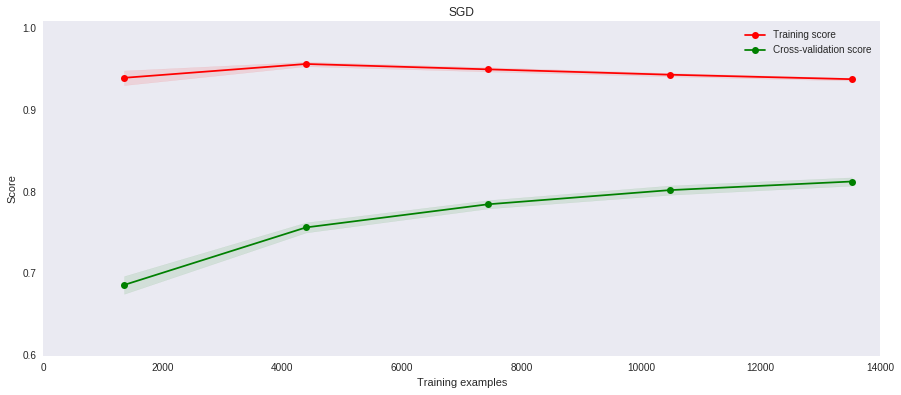

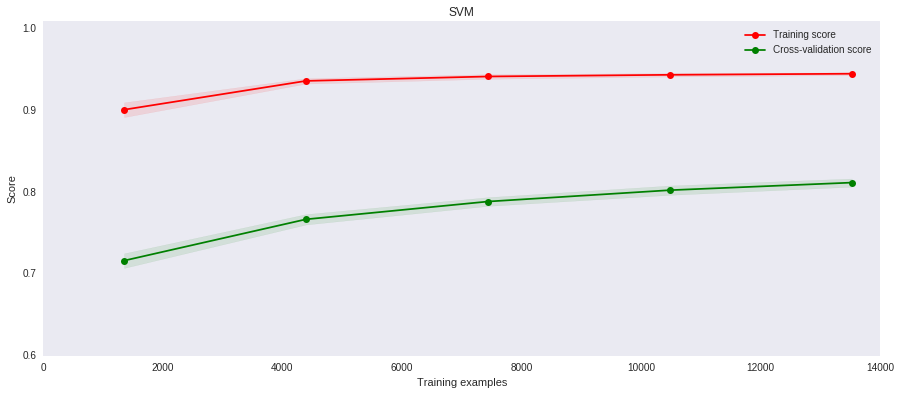

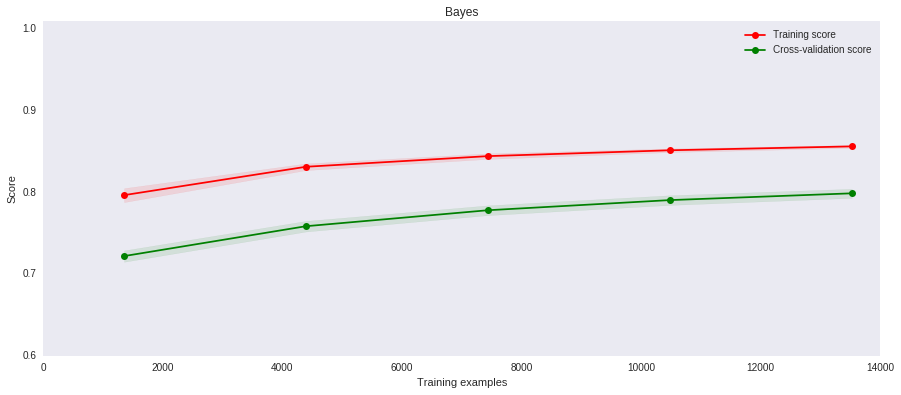

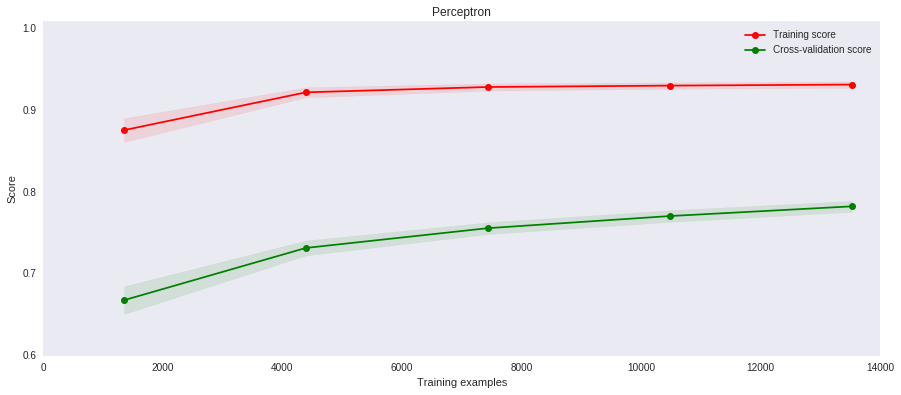

CPU times: user 1min 19s, sys: 9.66 s, total: 1min 29s
Wall time: 25min 14s
Perceptron : 0.783011754269
SGD        : 0.813446440452
Bayes      : 0.798975382568
SVM        : 0.812100243957


In [25]:
models_to_test = [
    ('SGD', SGDClassifier(n_iter=50, loss='modified_huber')),
    ('SVM', svm.LinearSVC()),
    ('Bayes', naive_bayes.MultinomialNB()),
    ('Perceptron', Perceptron())
    ]

%time scores = learning_curves(models_to_test, tweets, n_jobs = 2)

for m in scores:
    print '{0:10} : {1}'.format(m[0], np.mean(scores[m], axis=1).max())

1


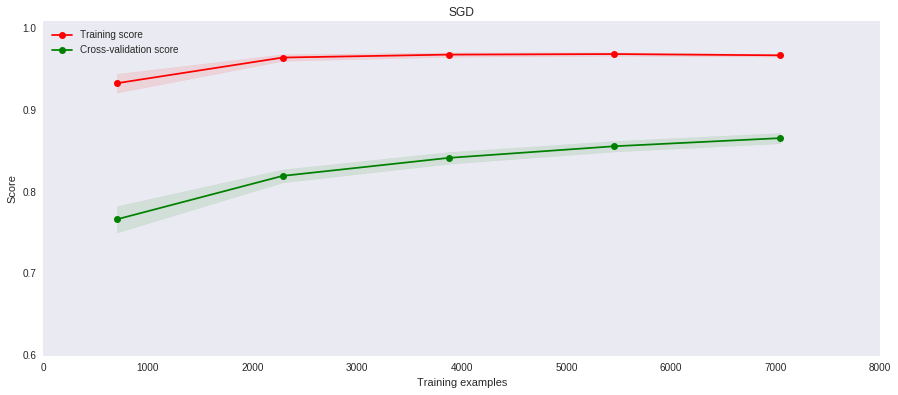

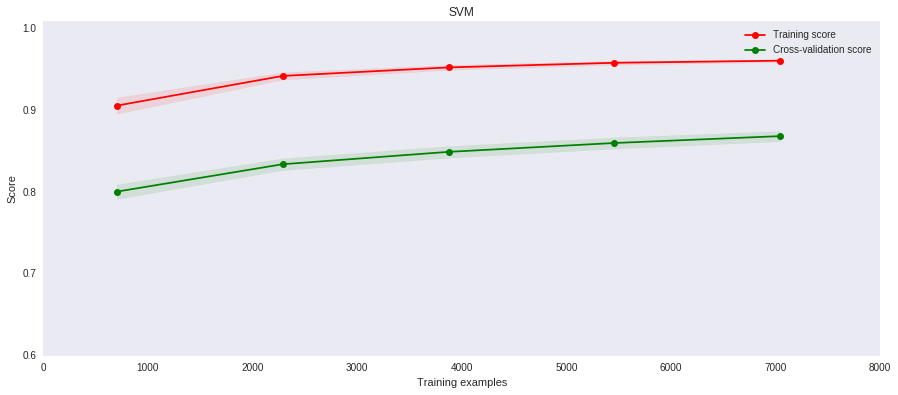

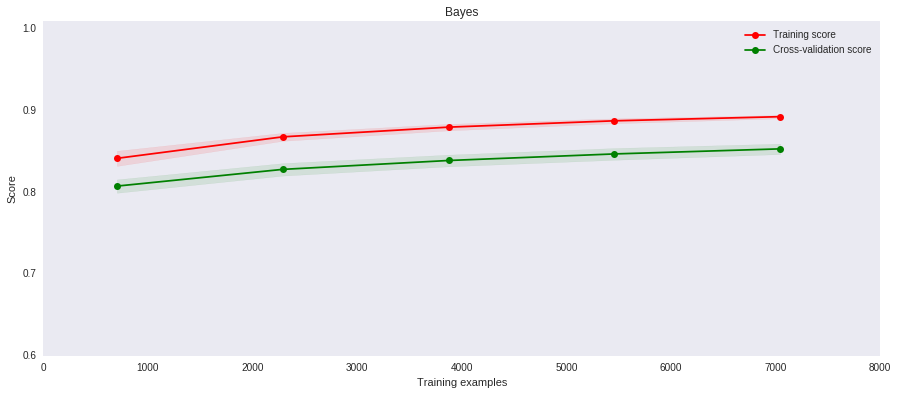

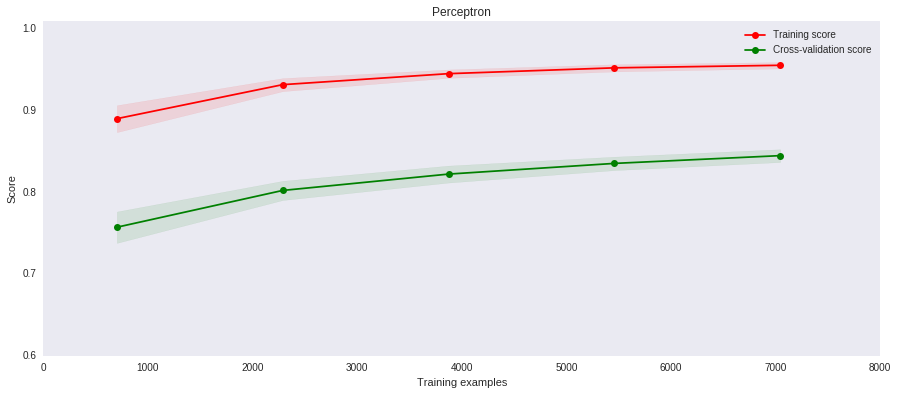

CPU times: user 21min 59s, sys: 7 s, total: 22min 6s
Wall time: 22min
Perceptron : 0.845119250426
Bayes      : 0.853419931857
SGD        : 0.866567291312
SVM        : 0.869016183986


In [42]:
%time scores = learning_curves(models_to_test, bank_tweets)

for m in scores:
    print '{0:10} : {1}'.format(m[0], np.mean(scores[m], axis=1).max())

1


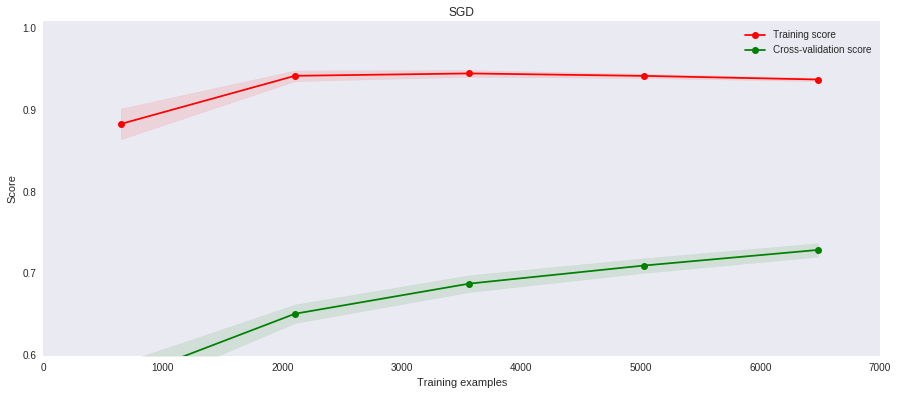

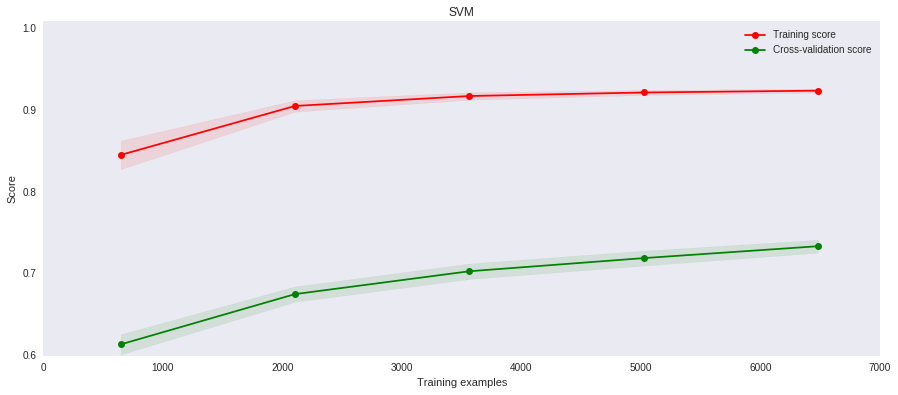

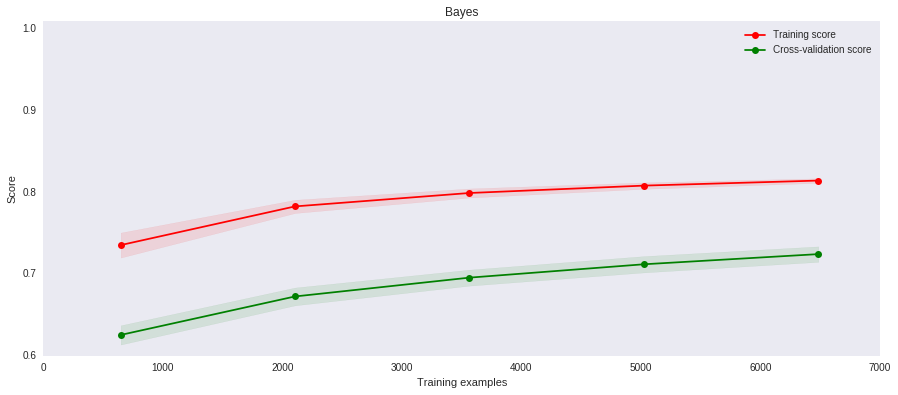

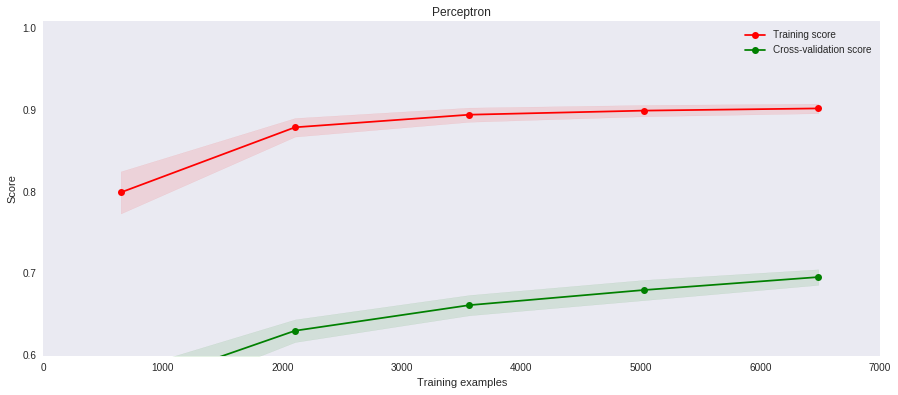

CPU times: user 25min 44s, sys: 11.4 s, total: 25min 55s
Wall time: 25min 51s
Perceptron : 0.696395187413
Bayes      : 0.72451642758
SGD        : 0.729676075891
SVM        : 0.734220268394


In [43]:
%time scores = learning_curves(models_to_test, tkk_tweets)

for m in scores:
    print '{0:10} : {1}'.format(m[0], np.mean(scores[m], axis=1).max())

Как видно из кривых обучения, все модели показывают примерно одинаковый результат, для дальнейшних тестов будет взята SVM т.к. результат, полученный с ней, лучший и время обучения не так велико.
Отзывы о банках проще классифицировать чем отзывы об операторах связи.

In [45]:
models_to_test = [('SVM', svm.LinearSVC())]

Улучшится ли качество классификации, если отбросить твиты о нескольких объектах и оставить только однозначные?

In [46]:
bank_tweets_filtered = bank_tweets[bank_tweets.apply(object_count, axis=1, args=(banks, )) == 1]
tkk_tweets_filtered = tkk_tweets[tkk_tweets.apply(object_count, axis=1, args=(tkk, )) == 1]

1


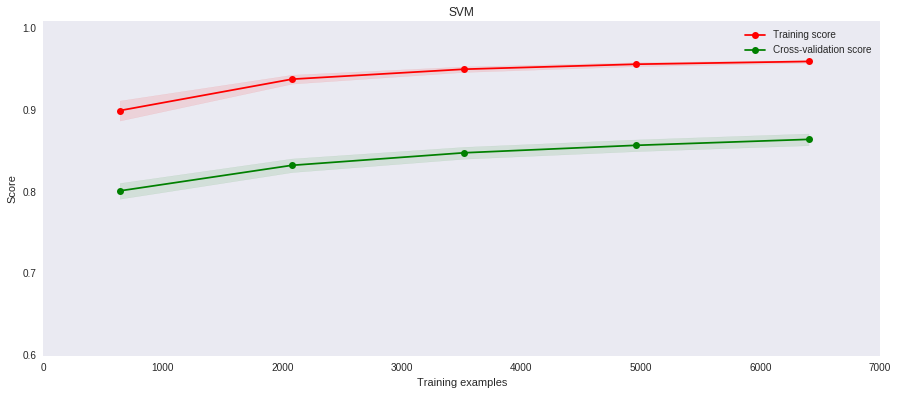

CPU times: user 4min 29s, sys: 1.71 s, total: 4min 31s
Wall time: 4min 29s
SVM        : 0.865042174321


In [48]:
%time scores = learning_curves(models_to_test, bank_tweets_filtered)
for m in scores:
    print '{0:10} : {1}'.format(m[0], np.mean(scores[m], axis=1).max())

1


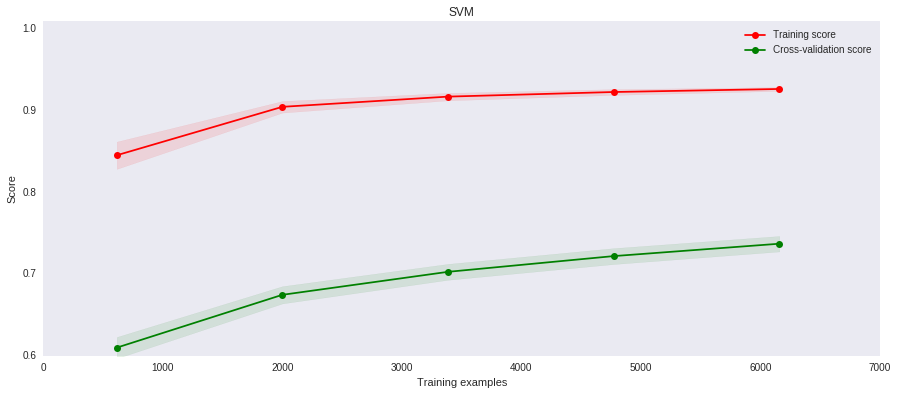

CPU times: user 5min 59s, sys: 2.32 s, total: 6min 2s
Wall time: 6min
SVM        : 0.737251461988


In [47]:
%time scores = learning_curves(models_to_test, tkk_tweets_filtered)
for m in scores:
    print '{0:10} : {1}'.format(m[0], np.mean(scores[m], axis=1).max())

Как видно из результатов, наличие твитов о нескольких объектах почти не влияет на качество (разница в несколько сотых).

В предыдущих тестах использовалась tfidf векторизация. Сравним результаты с использованием данного метода с другими (для данного датасета использовать delta-tfidf нельзя т.к. задача небинарной классификации).

1


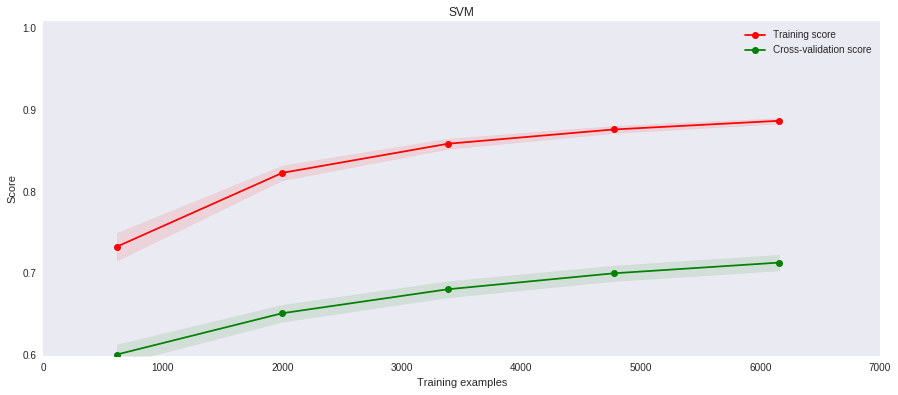

CPU times: user 8min 5s, sys: 2.22 s, total: 8min 7s
Wall time: 8min 6s
SVM        : 0.714156920078


In [50]:
vectorizer = CountVectorizer(min_df = 5, max_df=0.95, stop_words = stops, tokenizer = tweet_tokenize)
%time scores = learning_curves(models_to_test, tkk_tweets_filtered, vectorizer=vectorizer)
for m in scores:
    print '{0:10} : {1}'.format(m[0], np.mean(scores[m], axis=1).max())

1


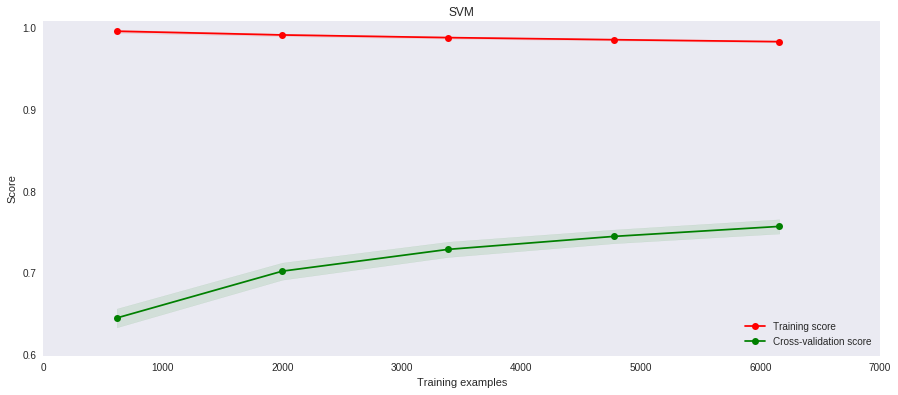

CPU times: user 7min 10s, sys: 5.43 s, total: 7min 15s
Wall time: 7min 16s
SVM        : 0.758450292398


In [53]:
vectorizer = HashingVectorizer(stop_words = stops, tokenizer = tweet_tokenize)
%time scores = learning_curves(models_to_test, tkk_tweets_filtered, vectorizer=vectorizer)
for m in scores:
    print '{0:10} : {1}'.format(m[0], np.mean(scores[m], axis=1).max())

Повлияет ли на качество классификации количество н-грамм?

1


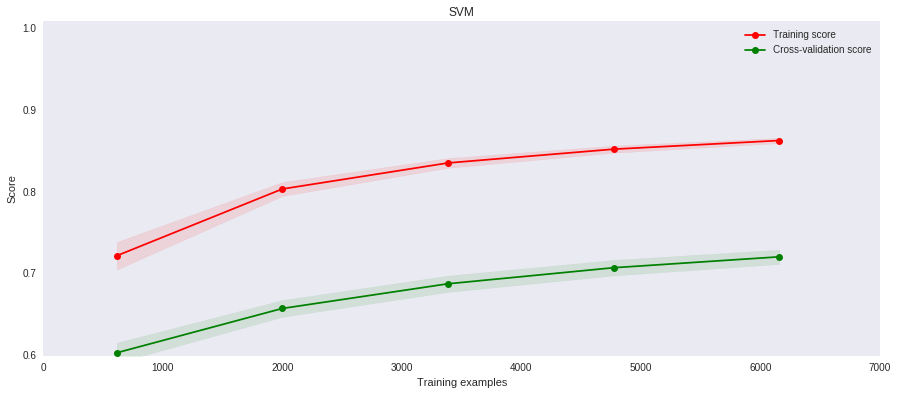

CPU times: user 6min 25s, sys: 2.34 s, total: 6min 27s
Wall time: 6min 26s
SVM             : 0.721218323587
1


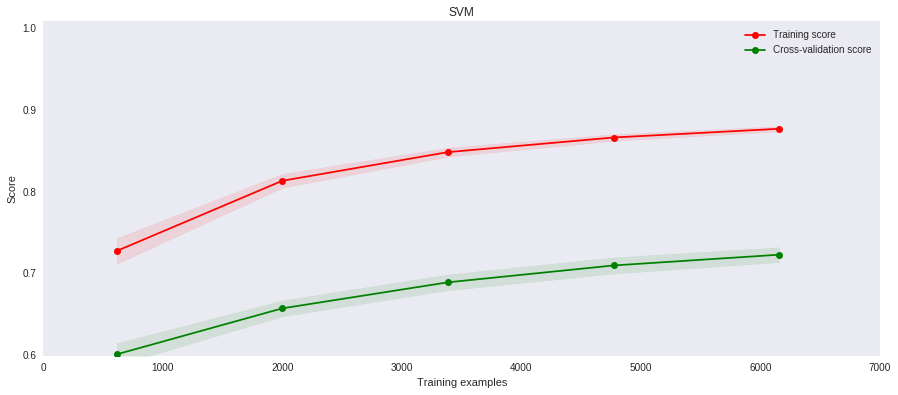

CPU times: user 7min 52s, sys: 3.71 s, total: 7min 56s
Wall time: 7min 54s
SVM             : 0.723820662768
1


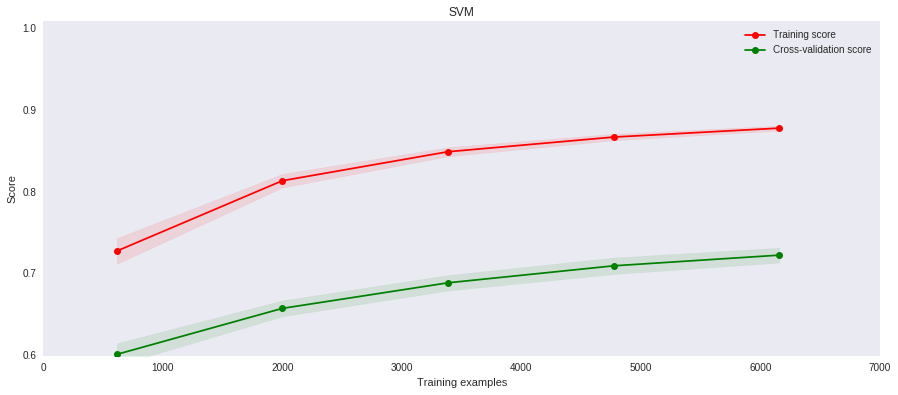

CPU times: user 8min 43s, sys: 3.49 s, total: 8min 47s
Wall time: 8min 43s
SVM             : 0.723269980507


In [57]:
for k in [1, 2, 3]:
    vectorizer = TfidfVectorizer(min_df = 5, max_df=0.95, stop_words = stops, tokenizer = tweet_tokenize, ngram_range = (1, k))
    model = [('SVM with {} n-grams'.format(k),  svm.LinearSVC(dual=True)) ]
    %time scores = learning_curves(models_to_test, tkk_tweets_filtered, vectorizer=vectorizer)
    for m in scores:
        print '{0:15} : {1}'.format(m[0], np.mean(scores[m], axis=1).max())

Результаты теста показали, что количество н-грам так же почти не влияет на результат.

## Частота слов
Подсчитаем частоту слов в документах разной тональности из двух датасетов: про банки и про операторов связи.

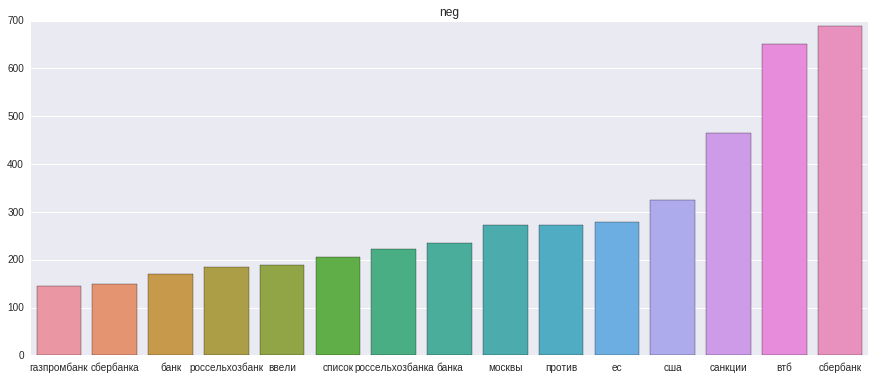

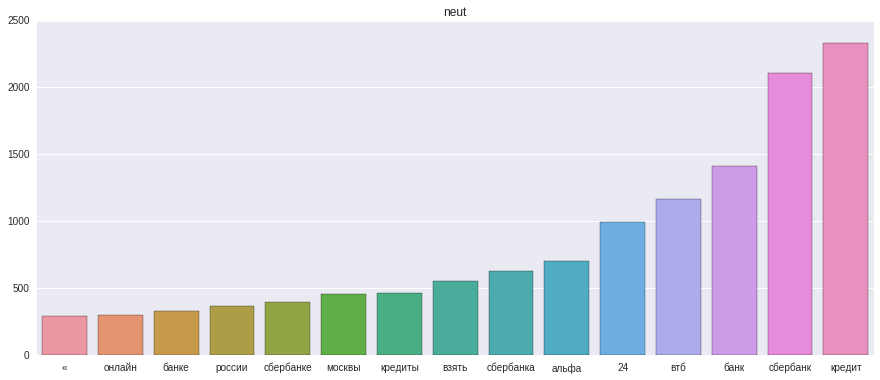

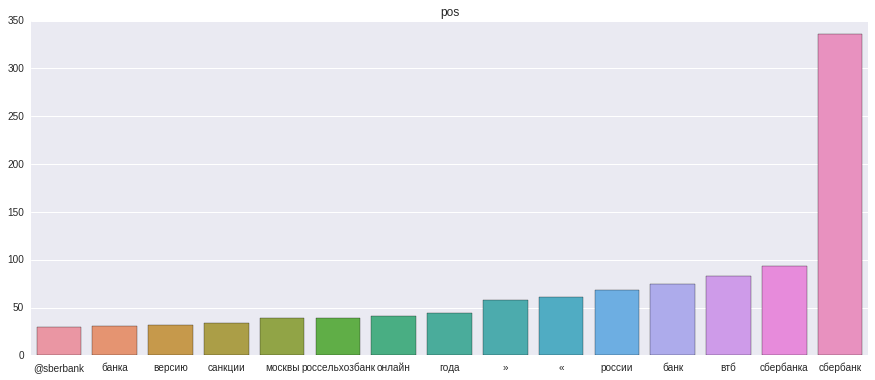

In [64]:
sentiments = [('neg', -1), ('neut', 0), ('pos', 1)]
for s in sentiments:
    X_tweets = list(bank_tweets[bank_tweets['ttype'] == s[1]]['ttext'])

    words = list()

    for tweet in X_tweets:
        words += remove_stop_words(tweet_tokenize(tweet))

    words_counts = Counter(words)
    words_counts = sorted([(w, words_counts[w]) for w in words_counts], key=lambda x: x[1])

    pos_words = words_counts[-15:]

    plt.figure(figsize=FIG_SIZE)
    sns.barplot(x=[w[0] for w in pos_words], y=[w[1] for w in pos_words])
    sns.plt.title(s[0])

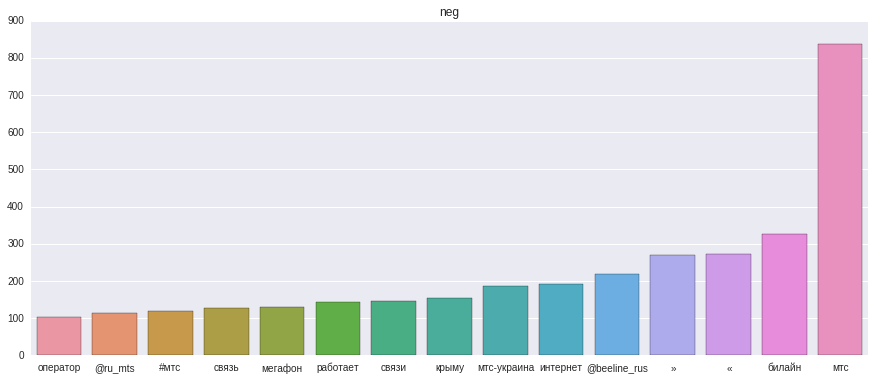

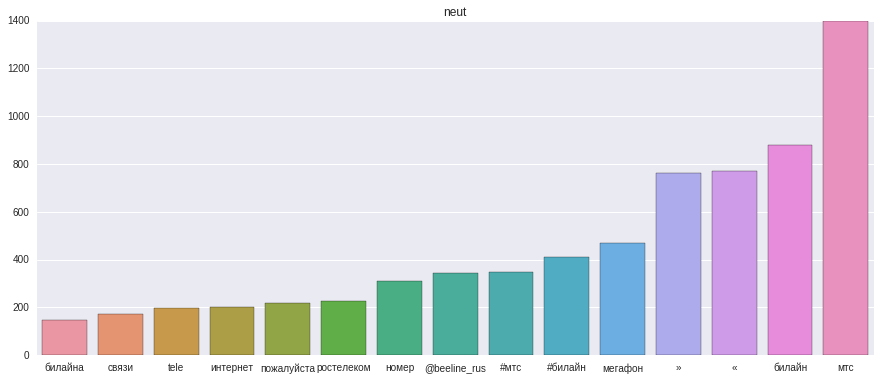

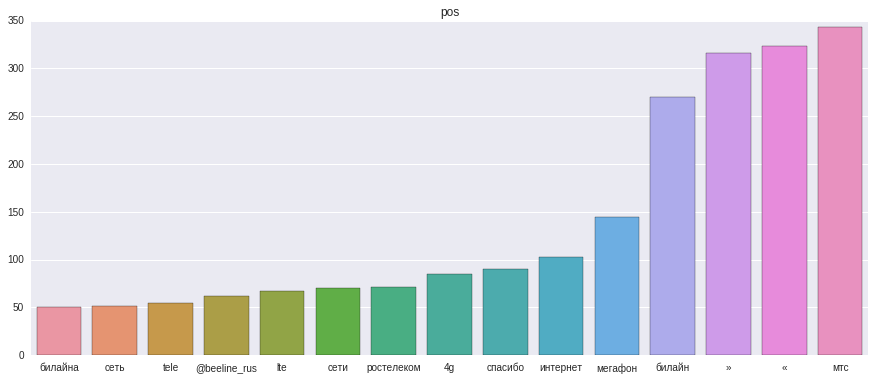

In [65]:
sentiments = [('neg', -1), ('neut', 0), ('pos', 1)]
for s in sentiments:
    X_tweets = list(tkk_tweets[tkk_tweets['ttype'] == s[1]]['ttext'])

    words = list()

    for tweet in X_tweets:
        words += remove_stop_words(tweet_tokenize(tweet))

    words_counts = Counter(words)
    words_counts = sorted([(w, words_counts[w]) for w in words_counts], key=lambda x: x[1])

    pos_words = words_counts[-15:]

    plt.figure(figsize=FIG_SIZE)
    sns.barplot(x=[w[0] for w in pos_words], y=[w[1] for w in pos_words])
    sns.plt.title(s[0])

## Тематическое моделирование по банкам и операторам связи.

In [76]:
TOP_WORDS = 5

In [77]:
tf_vectorizer = CountVectorizer(min_df = 3, max_df = 0.95, stop_words = stops, tokenizer = tweet_tokenize)
tf = tf_vectorizer.fit_transform(bank_tweets['ttext'].apply(remove_retweet).apply(convert_to_normal))

lda = LatentDirichletAllocation(n_topics=TOPICS_COUNT, max_iter=5,
                                learning_method='online', learning_offset=50.,
                                random_state=0).fit(tf)

tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, TOP_WORDS)

Topic #0:
кредит сбербанк втб взять потребительский
Topic #1:
банкомат банк райффайзный миллион втб
Topic #2:
сбербанк #сбербанк свой сбербанка #news
Topic #3:
сбербанк ставка вклад сайт почему
Topic #4:
сбербанк онлайн россия россии рф
Topic #5:
карта кредитный сбербанк банка альфа
Topic #6:
« сбербанк ипотека россельхозбанк год
Topic #7:
новый клиент работа день оплата
Topic #8:
банк кредит москва втб сбербанк
Topic #9:
втб санкция сбербанк россельхозбанк сша
()


In [78]:
tf_vectorizer = CountVectorizer(min_df = 3, max_df = 0.95, stop_words = stops, tokenizer = tweet_tokenize)
tf = tf_vectorizer.fit_transform(tkk_tweets['ttext'].apply(remove_retweet))

lda = LatentDirichletAllocation(n_topics=TOPICS_COUNT, max_iter=5,
                                learning_method='online', learning_offset=50.,
                                random_state=0).fit(tf)

tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, TOP_WORDS)

Topic #0:
смс мтс :) beeline почему
Topic #1:
вымпелком мтс quot оборудования мобильного
Topic #2:
билайн #мтс интернет день мтс
Topic #3:
мтс билайн номера мобильный интернет
Topic #4:
« мегафон билайн 3g сеть
Topic #5:
мтс связи работает билайн сегодня
Topic #6:
« мтс-украина мтс крыму абонентов
Topic #7:
билайна мтс связью билайн модем
Topic #8:
#билайн номер мтс пожалуйста ваш
Topic #9:
мтс связь украина вчера скачать
()
